In [2]:
import argparse
import concurrent.futures
import json
import os
import subprocess
import sys
from collections import defaultdict
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional

import dash_core_components as dcc
import dash_html_components as html
import gin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import sklearn.metrics
import tensorflow as tf
import tensorflow_probability as tfp
import yaml
from jupyter_dash import JupyterDash
from PIL import Image
from tqdm import tqdm
import mlflow

import lib_analysis
import lib_biased_mnist
import lib_plot
import lib_problem
import lib_toy

external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

tqdm.pandas()
gin.enter_interactive_mode()

/home/ericpts/.local/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

/home/ericpts/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
os.environ["MLFLOW_TRACKING_USERNAME"] = "exp-02.mlflow-yang.ericst"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "parolaeric"
remote_server_uri = "https://exp-02.mlflow-yang.inf.ethz.ch"
mlflow.set_tracking_uri(remote_server_uri)

In [6]:
exp = mlflow.get_experiment_by_name('biased_mnist_nadam')
df = mlflow.search_runs(exp.experiment_id)

In [7]:
def select_df(df, *restrictions):
    for col, val in restrictions:
        df = df[
            df[col] == str(val)
        ]
    return df

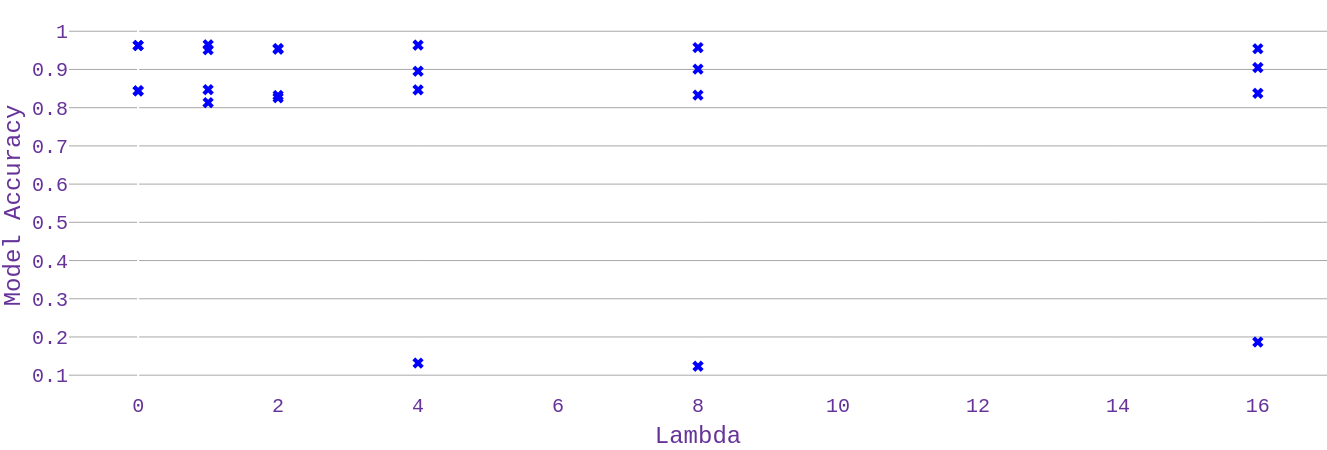

In [47]:
def lambda_figure(df):
    lambdas = np.asarray(sorted([int(x) for x in np.unique(df['params.Problem.lambda_'])]))
    def select_metric(metric_name: str):
        vals = []
        for l in lambdas:
            d = select_df(df, ('params.Problem.lambda_', l))
            assert len(d) == 1, f"{d}"
            auroc = float(d[f'metrics.{metric_name}'])
            vals.append(auroc)
        vals = np.asarray(vals)
        return vals
    fig = go.Figure(data=[
        go.Scatter(x=lambdas, y=select_metric('test_ood_accuracy_0'), mode='markers'),
        go.Scatter(x=lambdas, y=select_metric('test_ood_accuracy_1'), mode='markers'),
        go.Scatter(x=lambdas, y=select_metric('test_id_accuracy_0'), mode='markers'),
        go.Scatter(x=lambdas, y=select_metric('test_id_accuracy_1'), mode='markers'),

    ])
    fig.update_traces(
        marker=dict(
            color='blue',
            size=10,
            symbol='x',
        ))
    
    fig.update_layout(
        xaxis_title="Lambda",
        yaxis_title="Model Accuracy",
        font=dict(
            family="Courier New, monospace",
            size=20,
            color="RebeccaPurple"
        ),
        showlegend=False,
        
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        yaxis_gridcolor = "darkgray",
        yaxis_showgrid=True,
        yaxis_gridwidth=1,

    )
    fig.update_layout(margin={'l': 0, 'r': 0, 't': 20, 'b': 0})
    return fig


lambda_figure(
    select_df(df,
          ('params.BiasedMnistScenario.background_noise_level', '0'),
          ('params.BiasedMnistScenario.training_data_label_correlation', "0.9"), 
          ('params.Problem.base_model', "mlp"),
          ('params.Problem.initial_lr', '0.01'),
    )
).show()

